# STA 863 Final Project - FHMM
*Factorial Hidden Markov Models* - Gharamani and Jordan


In [253]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.stats import multivariate_normal
import seaborn as sns
from music_comp import * ## pre-processing and metrics code
np.random.seed(17)

In [2]:
# Calculate log likelihood
# n is number of observations
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations 
# mu is a D x n mean matrix
def log_like(n, pi, Tmat, mu, C, Y, zstates):
    y_prob = np.zeros(n) # emission probabilities
    t_prob = 0 # transition matrix probabilities
    pi_prob = 0 # initial probability
    for i in range(0, M):
            pi_prob += np.log(pi[i][zstates[i][0]])
    
    for t in range(0, n):
        y_prob[t] = np.log(multivariate_normal.pdf(Y[:, t], mean = mu[:, t], cov = C))  
        
        for i in range(0, M):
            t_prob += Tmat[i][zstates[i][t-1], zstates[i][t]]
    ll = pi_prob + t_prob + np.sum(y_prob)        
    return(ll)

## 1. Generate Toy Data and Parameters

$$P({S_t, Y_t}) = P(S_1)P(Y_1 | S_1)\prod_{t=2}^T P(S_t | S_{t-1})P(Y_t | S_t)$$

- Assume three different chains, each with 5 hidden states each
- M = 3, K = (5, 5, 5)
- n = 10 observations, D = 3 (dimension of Gaussian)
- Normal Model

In [3]:
M = 3 ## Number of independent hidden state chains
K = np.array([5, 5, 5]) ## number of hidden states for each chain
D = 3 ## Dimension of Gaussian
n = 10 ## number of observations


## Generate distribtions
pi = [] ## initial distribution
Tmat = []  ## transition distribution
W = [] ## contribution to means matrices D x K
for i in range(0, M):
    vals = np.random.rand(K[i])
    pi.append(vals/np.sum(vals))
    vals1 = np.random.rand(K[i], K[i])
    Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
    W.append(10*np.random.rand(D, K[i]))
    
## Generate state variables
S = []
for i in range(0, M):
    zstates = np.arange(0, K[i], dtype = int)
    z = np.zeros(n, dtype = int)
    zmat = np.zeros((K[i], n), dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
    zmat[z[0], 0] = 1
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        zmat[z[j], j] = 1
    S.append(zmat)
#x = np.random.normal(size=D)
#y = np.random.normal(size=D)
#z = np.vstack((x, y))
#C = np.cov(z.T) ## covariance matrix
C = np.identity(D)
mu = np.zeros((D, n))
Y = np.zeros((D, n))
for t in range(0, n):
    for i in range(0, M):
        mu[:, t] += np.dot(W[i], S[i][:, t])
    Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)


In [4]:
#C_new = np.dot((np.array([1, 2, 1] ) - np.array([0, 0.7, 0]))[np.newaxis].transpose(), 
#               (np.array([1, 2, 1] ) - np.array([0, 0.7, 0]))[np.newaxis])
#print(np.all(np.linalg.eigvals(C_new) > 0))
#C_new

In [5]:
print("Pi")
print(np.round(pi, 3))
print("Tmat")
print(np.round(Tmat, 3))
print("W")
print(np.round(W, 3))
print("C")
print(np.round(C, 3))
print("Z states")
print([np.where(S[0][:, t] == 1)[0][0] for t in range(n)])
print([np.where(S[1][:, t] == 1)[0][0] for t in range(n)])
print([np.where(S[2][:, t] == 1)[0][0] for t in range(n)])
print('Log-Likelihood')
zstore = [[np.where(S[0][:, t] == 1)[0][0] for t in range(n)], [np.where(S[1][:, t] == 1)[0][0] for t in range(n)],
         [np.where(S[2][:, t] == 1)[0][0] for t in range(n)]]
log_like(n, pi, Tmat, mu, C, Y, zstore)

Pi
[[0.157 0.283 0.102 0.036 0.42 ]
 [0.22  0.263 0.04  0.23  0.248]
 [0.151 0.167 0.29  0.245 0.146]]
Tmat
[[[0.29  0.281 0.254 0.017 0.158]
  [0.338 0.021 0.309 0.314 0.018]
  [0.254 0.215 0.233 0.188 0.11 ]
  [0.121 0.228 0.161 0.32  0.17 ]
  [0.106 0.111 0.041 0.528 0.215]]

 [[0.376 0.013 0.177 0.198 0.236]
  [0.219 0.058 0.437 0.029 0.257]
  [0.215 0.353 0.073 0.031 0.327]
  [0.005 0.236 0.228 0.259 0.272]
  [0.169 0.146 0.192 0.442 0.051]]

 [[0.025 0.271 0.221 0.227 0.256]
  [0.221 0.122 0.152 0.251 0.254]
  [0.135 0.052 0.227 0.195 0.391]
  [0.159 0.163 0.118 0.253 0.306]
  [0.058 0.296 0.073 0.139 0.433]]]
W
[[[1.988 8.314 5.68  0.823 5.45 ]
  [1.59  6.768 1.185 4.45  8.88 ]
  [7.973 0.68  9.608 6.592 7.188]]

 [[6.755 8.585 6.929 7.851 3.533]
  [2.202 2.454 7.274 0.641 4.537]
  [4.877 6.409 1.062 5.736 9.603]]

 [[4.829 5.407 7.112 6.874 0.37 ]
  [8.882 1.886 7.82  6.439 4.854]
  [9.29  2.699 8.142 6.95  2.355]]]
C
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Z states
[4, 3, 3, 1, 2

-36.794003412324884

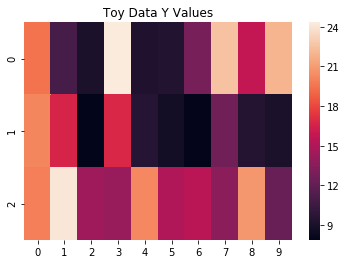

In [6]:
sns.heatmap(Y)
plt.title("Toy Data Y Values")
pass

# E - Step

## 2. Gibbs Sampling 

$$S_t^{(m)} \propto P(S_t^{(m)} | S_{t-1}^{(m)})P(S_{t+1}|S_t^{(m)})P(Y_t | S_t^{(1)}, \ldots, S_t^{(M)})$$

In [7]:
# Calculate transition matrix from a vector
# q is a vector from 0 to m different states
# return m x m transition matrix b
from collections import Counter
def trans_mat(q, m):
    b = np.zeros((m,m))
    for (x,y), c in Counter(zip(q, q[1:])).items():
        b[x, y] = c
    return(b)


# t is the time step to be updated
# y is the observed value at that time step
# M is the number of hidden Markov chains
# K is a vector of number of hidden states for each chain
# C is covariance matrix for emission distribution
# W is a list of M D x K matrix, columns contribution to mean of each state variable 
# S is a M long list of current states, each element of list is K[i] x n long (n number of observations)
# update is which of M chains to calculate emission probabilities for, for every K[i] possible values
# output is a K[update] vector of density of y for each possible value of S[update]
def y_density(t, y, M, K, S, C, W, update):
    ydense = np.zeros(K[update]) ## output density for each possible value of S[update]
    Stemp = S
    for i in range(0, K[update]):
        mu = 0
        Stemp[update][:, t] = 0
        Stemp[update][i, t] = 1 # state variable value to calculate probability for
        for j in range(0, M):
            mu += np.dot(W[j], Stemp[j][:, t])
        ydense[i] = multivariate_normal.pdf(y, mean = mu, cov = C)
    return(ydense)



# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# it is the number of iterations to run for the Gibbs Sampler
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10):
    # Randomly initialize state vectors
    small = 10E-5
    S = []
    zstates = []
    for i in range(0, M):
        s = np.zeros((K[i], n), dtype = int)
        ind = np.random.choice(range(0, K[i]), n)
        s[ind, range(0, n)] = 1
        zz = np.zeros((it, n), dtype = int)
        zz[0, :] = ind
        zstates.append(zz)
        S.append(s)
        
    for l in range(1, it):
        ## update one  chain at a time
        for i in range(0, M):
            ## step through each time point
            for t in range(0, n):
                ## select P(S_t | S_t-1)
                if t == 0:
                    tback = np.ones(K[i])
                else:
                    prev = zstates[i][l-1, t-1]
                    tback = Tmat[i][prev, :]
                ## select P(S_t+1 | S_t)
                if t == (n-1):
                    tfore = np.ones(K[i])
                else:
                    fore = zstates[i][l-1, t]
                    tfore = Tmat[i][fore, :]
                ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
                ydense = y_density(t, Y[:, t], M, K, S, C, W, i)
                
                ## Calculate probability for each state for S_t^i
                probvec = np.multiply(np.multiply(tback, tfore) , ydense)
                if np.sum(probvec) == 0: # check if all states have 0 probability
                    probvec = np.ones(len(probvec)) # reset to equal probs if so
                probvec = probvec/sum(probvec)
                ## sample state and update vector
                zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
                S[i][zstates[i][l, t], t] = 1
    
    ## Calculate expectations
    # <S_t^(m)>
    St = []
    Smm = []
    for i in range(0, M):
        uprobs = [np.unique(zstates[i][:, t], return_counts = True)[1]/it for t in range(0,n)] # calculate probs
        zmat = np.zeros((K[i], n))
        inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
        for t in range(n):
            zmat[inds[t], t] += uprobs[t] + small
        #zmat = zmat/np.sum(zmat)
        St.append(zmat)
        # calculate trans mat
        Smm.append(np.stack([trans_mat(zstates[i][:, t], K[i])/(it-1) for t in range(0, n)], axis = 2))  
    
    
    
    # <S_t^(m)S_t^(n)>
    Snm = np.zeros((sum(K), sum(K), n))
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    s1 = np.zeros((K[i], K[i]))
                    mm = np.unique(zstates[i][:, t], return_counts = True)
                    s1[mm[0], mm[0]] = mm[1]/it
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = s1
                s2 = np.zeros((K[i], K[j]))
                for l in range(0, it):
                    s2[zstates[i][l, t], zstates[j][l, t]] += 1
                Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = s2/it
    
    return(St, Smm, Snm)

## 3. Completely Factorized VI

In [8]:
## KL divergence (to monitor convergence of approximation) - equation C.9
# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# Return KL divergence
def KL_factorized(n, M, K, Y, theta, pi, Tmat, W, C):
    term1 = 0
    term2 = 0
    term3 = 0
    term4 = 0
    term5 = 0
    term6 = 0
    term7 = 0
    small = 10E-10
    for t in range(n):
        term2 += np.dot(Y[:, t].transpose() , np.dot(np.linalg.inv(C), Y[:, t]))
        for i in range(M):
            term1 += np.dot(theta[i][:, t].transpose(), np.log(theta[i][:, t] + small))
            term3 += np.dot(np.dot(Y[:, t].transpose(), np.linalg.inv(C)), np.dot(W[i], theta[i][:, t]))
            for j in range(M):
                if i != j:
                    targ1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), W[j])
                    targ2 = np.dot(theta[j][:, t], theta[i][:, t].transpose())
                    term4 += np.trace(np.dot(targ1, targ2))
            
            term5 += np.trace(np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), 
                                     np.dot(W[i], np.diag(theta[i][:, t]))))
            if t > 0:
                term7 += np.trace(np.outer(theta[i][:, t-1], 
                                           np.dot(theta[i][:, t].transpose(), np.log(Tmat[i] + small))))
                
    for i in range(M):
        term6 += np.dot(theta[i][:, 0].transpose(), np.log(pi[i] + small))
        
    # Find normalizing constants
    
    KL = term1 + 0.5*(term2 - 2*term3 + term4 + term5) + term6 + term7
    return(KL)
    

In [9]:
# Softmax operator on input vector x
def softmax(x):
    y = x - np.max(x)
    return(np.exp(y)/np.sum(np.exp(y)))


# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# theta is a M long list of K[m] x n matrices from completely factorized VI approx
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# tol is the tolerance for convergence of the KL divergence to stop the iterations
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def factorized_VI(n, M, K, Y, pi, Tmat, W, C, tol):
    D = Y.shape[0]
    thetaOld = []
    thetaNew = []
    for i in range(M):
        vals1 = np.random.rand(K[i], n)
        thetaOld.append(vals1/np.sum(vals1, axis=0)[None, :])
        thetaNew.append(np.zeros((K[i], n)))

    KLOld = 10E10
    small = 10E-10
    convergence = 0
    iterations = 0
    criteria = 10E10
    maxit = 20 ## max number of iterations
    while(convergence == 0):
        for i in range(M):
            for t in range(n):
                ## Calculate Y tilde
                s1 = np.zeros((D, 1))
                for j in np.delete(np.arange(M), i):
                    s1 += np.dot(W[j], thetaOld[j][:, t])[np.newaxis].transpose()
                Ytilde = Y[:, t][np.newaxis].transpose() - s1
                ## Calculate delta term
                delta = np.dot(W[i].transpose(), np.dot(np.linalg.inv(C), W[i])).diagonal()
                ## Calculate first term
                term1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), Ytilde)
                term2 = delta[np.newaxis].transpose()/2
                if t > 0:
                    term3 = np.dot(np.log(Tmat[i] + small), thetaOld[i][:, t-1])[:, np.newaxis]
                else:
                    term3 = np.log(pi[i] + small)[np.newaxis].transpose()
                if t < n-1:
                    term4 = np.dot(np.log(Tmat[i] + small).transpose(), thetaOld[i][:, t+1])[np.newaxis].transpose()
                else:
                    term4 = np.zeros(K[i])[np.newaxis].transpose()
                ## Find sum
                sumterm = term1 - term2 + term3 + term4
                thetaNew[i][:, t] = softmax(sumterm).transpose()





        ## Check KL divergence



        #KLNew = KL_factorized(n, M, K, Y, thetaNew, pi, Tmat, W, C)
        #print(KLNew)
        #criteria = abs(KLOld - KLNew)
        if criteria < tol or iterations > maxit:
            convergence = 1
        #else:
        #    convergence = 0
        #    KLOld = KLNew
        #    thetaOld = thetaNew

        iterations += 1

    ## Find expectations
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    # Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
    # Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
    St = [np.zeros((K[i], n)) for i in range(M)]
    Smm = [np.zeros((K[i], K[i], n)) for i in range(M)]
    Snm = np.zeros((np.sum(K), np.sum(K), n))
    for i in range(M):
        for t in range(n):
            St[i][:, t] = thetaNew[i][:, t]
            if t == 0:
                Smm[i][:, :, t] = np.outer(pi[i], thetaNew[i][:, t])
            else:
                Smm[i][:, :, t] = np.outer(thetaNew[i][:, t-1], thetaNew[i][:, t])

    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = np.diag(thetaNew[i][:, t])
                else:
                    Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = np.outer(thetaNew[i][:, t], thetaNew[j][:, t])
                    
    return(St, Smm, Snm)

# 4. Structural VI

In [10]:
## Forward- Backward Algorithm
#Function using the log-sum-exp trick#
def logSumExp(a):
    if np.all(np.isinf(a)):
        return np.log(0)
    else:
        b = np.max(a)
        return(b + np.log(np.sum(np.exp(a-b))))


def pForwardFHMM(g):
    n, m = g.shape
    pXf = logSumExp(g[n-1,:])
    return(pXf)

    
def forwardAlgFHMM(n, m, pi, Tmat, phi):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + (phi[i, 0])
    
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :]) + np.asarray(Tmat[:,l]) + (phi[l, j]))
    return(g)

def backwardAlgFHMM(n, m, pi, Tmat, phi):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + phi[:, j+1])
    
    return(r)

In [11]:
# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# theta is a M long list of K[m] x n matrices from completely factorized VI approx
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# tol is the tolerance for convergence of the KL divergence to stop the iterations
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def structural_VI(n, M, K, Y, pi, Tmat, W, C, tol):
    D = Y.shape[0]
    small = 10E-10
    ## Work with log of parameters
    piL = [np.log(pi[i] + small) for i in range(M)]
    TmatL = [np.log(Tmat[i] + small) for i in range(M)]
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    St = [np.zeros((K[i], n)) for i in range(M)]
    ## h matrices which serve as emission distributions for forward-backward
    phi = [np.zeros(shape = (K[i], n)) for i in range(M)]
    ## Randomly initialize St
    for i in range(M):   
        vals = np.random.rand(K[0], n)
        St[i] = vals/np.sum(vals, axis=0)[None, :]
    
    
    pOld = 10E10#*np.ones(M)
    pNew = np.zeros(M)
    convergence = 0
    iterations = 0
    criteria = 10E10
    maxit = 20 ## max number of iterations
    while(convergence == 0):
        for i in range(M):
            ## 1. Find ht = phi ##

            ## Calculate delta term
            delta = np.dot(W[i].transpose(), np.dot(np.linalg.inv(C), W[i])).diagonal()

            for t in range(n):
                ## Calculate Y tilde
                s1 = np.zeros((D, 1))
                for j in np.delete(np.arange(M), i):
                    s1 += np.dot(W[j], St[j][:, t])[np.newaxis].transpose()
                Ytilde = Y[:, t][np.newaxis].transpose() - s1
                term1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), Ytilde)
                term2 = delta[np.newaxis].transpose()/2
                #phi[i][:, t] = np.exp(term1 - term2).transpose()
                phi[i][:, t] = (term1 - term2).transpose()


            ## 2. Run Forwards-Backwards Algorithm

            g = forwardAlgFHMM(n, K[i], piL[i], TmatL[i], phi[i])
            h = backwardAlgFHMM(n, K[i], piL[i], TmatL[i], phi[i])
            pNew[i] = pForwardFHMM(g)
            #print(g)
            #print(pForward(g))

            ## 3. Update expectations
            for t in range(0, n):
                for j in range(0, K[i]):
                    St[i][j, t] = np.exp(g[t, j] + h[t, j] - pNew[i])
                    
            #print(np.sum(St[i]))
        ## Check log-likelihood
        #print(KLNew)
        #print(pOld)
        #print(pNew)
        criteria = abs(pOld - np.max(pNew))
        if criteria < tol or iterations > maxit:
            convergence = 1
        else:
            convergence = 0
            pOld = np.max(pNew)
            #thetaOld = thetaNew

        iterations += 1




    
    ## Find expectations
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    # Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
    # Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
    
    ## St already found above
    Smm = [np.zeros((K[i], K[i], n)) for i in range(M)]
    for i in range(M):
        for t in range(n):
            if t == 0:
                Smm[i][:, :, t] = np.outer(pi[i], St[i][:, t])
            else:
                Smm[i][:, :, t] = np.outer(St[i][:, t-1], St[i][:, t])
    
    #intermed = Smm[m][:, :, t]/np.sum(Smm[m][:, :, t])
    #Smm[m][:, :, t] = np.exp(intermed)/np.sum(np.exp(intermed)) ## renormalize
    
#     for m in range(M):
#         for t in range(0, n):
#             for i in range(0, K[m]):
#                 for j in range(0, K[m]):
#                     if t == 0:
#                         #Smm[m][i, j, t] = np.exp(TmatL[m][i,j] + phi[m][j, t] + piL[m][i] + h[t, j] - pNew[m])
#                         Smm[m][i, j, t] = TmatL[m][i,j] + phi[m][j, t] + piL[m][i] + h[t, j] - pNew[m]
#                     else:
#                         #Smm[m][i, j, t] = np.exp(TmatL[m][i,j] + phi[m][j, t] + g[t-1, i] + h[t, j] - pNew[m])
#                         Smm[m][i, j, t] = TmatL[m][i,j] + phi[m][j, t] + g[t-1, i] + h[t, j] - pNew[m]
            
#             #print(np.sum(Smm[m][:, :, t]))
#             if np.sum(Smm[m][:, :, t]) < small:
#                 Smm[m][:, :, t] += small
            
#             intermed = Smm[m][:, :, t]/np.sum(Smm[m][:, :, t])
#             Smm[m][:, :, t] = np.exp(intermed)/np.sum(np.exp(intermed)) ## renormalize
    
    
    Snm = np.zeros((np.sum(K), np.sum(K), n))
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = np.diag(St[i][:, t])
                else: ## Assume independence
                    Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = np.outer(St[i][:, t], St[j][:, t])
                    
    return(St, Smm, Snm)

In [12]:
# import warnings

# # warnings.simplefilter("always")
# # for i in range(10):
# #     print i
# #     warnings.warn('this is a warning message')
# warnings.simplefilter('error')
# for i in range(100):
#     print(i)
#     St, Smm, Snm = structural_VI(n, M, K, Y, pi, Tmat, W, C_new, tol = 1E-5)
#     W, pi, Tmat, C_new = Mstep(M, K,  Y, St, Smm, Snm)
#     if not np.all(np.linalg.eigvals(C_new) > 0):
#         print(C_new)
#         break
#     #print(np.all(np.linalg.eigvals(C_new) > 0))

### Check

In [13]:
#for i in range(M):
#    print(np.sum(St[i], axis = 0))
#    for t in range(n):
#        print(np.sum(Smm[i][:,:,  t]))
#        print(np.sum(St[i][:, t]))
#for t in range(n):
#    print(np.sum(Snm[0:5, 0:5, t]), np.sum(Snm[0:5, 5:10, t]), np.sum(Snm[0:5, 10:15, t]))
#    print(np.sum(Snm[5:10, 0:5, t]), np.sum(Snm[5:10, 5:10, t]), np.sum(Snm[5:10, 10:15, t]))
#    print(np.sum(Snm[10:15, 10:15, t]), np.sum(Snm[10:15, 10:15, t]), np.sum(Snm[10:15, 10:15, t]))
    

# M-Step

## 5. M-Step

$$ n = T$$
$$W^{new} = \left(\sum_{t=1}^T Y_t<S_t'>\right)\left(\sum_{t=1}^T<S_tS_t'>\right)^{\dagger}$$

** Add other update equations **

In [14]:
# M is number of hidden state Markov chains
# K is vector of number of hidden states for each Markov chain
# Y is the D x n matrix of observations
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
# output is a tuple of updated values from the M step
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations

def Mstep(M, K,  Y, St, Smm, Snm):
    ### Update W ###
    # Concatenate St to be sum(K) x 1 x t
    cSt = np.vstack([np.vstack(St[i]) for i in range(0, len(St))])
    s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
    s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
    Wnew = np.dot(s1, s2)
    # make Wnew back into list of matrices
    W = []
    pi = []
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0)
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for i in range(0, M):
        W.append(Wnew[:, ind1[i]:ind2[i]])
        ### Update pi ###
        pi.append(cSt[ind1[i]:ind2[i], 0])

    ### Update Transition matrices ###
    Tmat = []
    #St = [np.vstack(St[i]) for i in range(0, M)] ## stack St matrices for easier indexing
    for i in range(0, M):
        Tnew = np.zeros((K[i], K[i]))
        for j in range(0, K[i]):
            for l in range(0, K[i]):
                Tnew[j,l] =  np.sum(Smm[i][j, l, :])/np.max([np.sum(St[i][l, 0:(n-1)]), 10E-5])
        #print(np.sum(Tnew, axis=1)[:,None])
        if np.any(np.sum(Tnew, axis=1)[:,None]):
            #print("Yes")
            Tnew = Tnew + 10E-5
        #print(np.sum(Tnew, axis=1)[:,None])
        Tnew = Tnew/np.sum(Tnew, axis=1)[:,None]
        Tmat.append(Tnew)

    ### Update C covariance ###
    #s1 = np.dot(Y, Y.transpose())/n
    #s2 = np.zeros((D, D))
    #for t in range(0, n):
    #    for i in range(0, M):
    #        mult1 = np.dot(W[i], St[i][t, :])
    #        s2 += np.outer(mult1, Y[:, t].transpose())
    #C = s1 - s2/n
    
    #mutemp = np.zeros((D, n))
    #for i in range(0, M):
    #    mutemp += np.dot(W[i], np.vstack(St[i]))
    #C = np.dot(Y - mutemp, (Y - mutemp).transpose())/n
    
    term2 = np.zeros((D, D))
    for i in range(M):
        for t in range(n):
            term2 += np.dot(np.dot(W[i], St[i][:, t][:, np.newaxis]), Y[:, t][np.newaxis])


    C = np.dot(Y, Y.transpose())/n - term2/n
    
    return(W, pi, Tmat, C)

# 6. Inference: Run E-M Steps

In [15]:
# Y is D x n observation matrix
# M is number of hidden markov chains
# K is an 1 x M vector of the number of hidden states for each chain
# tol = tolerance for convergence
# inference is inference method to use, choices = Gibbs, FactorizedVI, StructuralVI
def FHMM(Y, M, K, tol, inference):
    D, n = Y.shape
    ## Initialize params
    pi = [] ## initial distribution
    Tmat = []  ## transition distribution
    W = [] ## contribution to means matrices D x K
    for i in range(0, M):
        vals = np.random.rand(K[i])
        pi.append(vals/np.sum(vals))
        vals1 = np.random.rand(K[i], K[i])
        Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
        W.append(10*np.random.rand(D, K[i]))
    C_old = np.identity(D)
    
    convergence = 0
    pOld = 10E10
    iterations = 0
    while(convergence == 0):
        
        ## E - Step
        if inference == "Gibbs":
            St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat, W, C_old, it = 10)
            
        if inference == "FactorizedVI":
            St, Smm, Snm = factorized_VI(n, M, K, Y, pi, Tmat, W, C_old, tol = 1E-5)
            
        if inference == "StructuralVI":
            St, Smm, Snm = structural_VI(n, M, K, Y, pi, Tmat, W, C_old, tol = 1E-5)
        
        ## M - Step
        W, pi, Tmat, C_new = Mstep(M, K,  Y, St, Smm, Snm)
        
        
        
        ## Check tolerance
        # sample S with new params
        ## Generate state variables
        #S = []
        #mu = np.zeros((D, n))
        #zstore = []
        #for i in range(0, M):
        #    zstates = np.arange(0, K[i], dtype = int)
        #    z = np.zeros(n, dtype = int)
        #    zmat = np.zeros((K[i], n), dtype = int)
        #    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        #    zmat[z[0], 0] = 1
        #    for j in range(1, n):
        #        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        #        zmat[z[j], j] = 1
        #    S.append(zmat)
        #    zstore.append(z)
        #for i in range(0, M):
        #    for j in range(1, n):
        #        mu[:, j] += np.dot(W[i], S[i][:, j])
        
        #pNew = log_like(n, pi, Tmat, mu, C, Y, zstore) 
        
        
        ## Monitor convergence of C since does not have label switching issues like other params
        criteria = np.linalg.norm(C_old - C_new)
        #criteria = abs(pOld - pNew)
        if criteria < tol or iterations > 500:
            convergence = 1
        else:
            convergence = 0
            #pOld = pNew
            C_old = C_new
    
        iterations += 1
        if iterations%10 == 0:
            print(iterations)
            print(criteria)
            
    if not np.all(np.linalg.eigvals(C_new) > 0):
           C_new = np.dot(C_new.transpose(), C_new)
    return(pi, Tmat, mu, C_new, W)
                    

In [16]:
pi_new, Tmat_new, mu_new, C_new, W_new = FHMM(Y, M, K, 0.1, "FactorizedVI")
print(C_new)
np.all(np.linalg.eigvals(C_new) > 0)

10
6.467832683124013
20
4.403414820318734
30
11.56125857930364
40
17.59258594518104
50
1.2156465908229521
60
2.6800360296176713
70
0.5801671537951137
80
2.9533522744481844
90
1.9485324821977155
[[19.76463853  3.86406901 -2.31018184]
 [ 3.86406901  1.5704837  -0.35730166]
 [-2.31018184 -0.35730166  0.62564909]]


True

In [17]:
pi_new, Tmat_new, mu_new, C_new, W_new = FHMM(Y, M, K, 2, "Gibbs")
print(C_new)
np.all(np.linalg.eigvals(C_new) > 0)

10
4.490965249737926
20
5.506070557434812
30
1.082176822226427
[[29.28927295 11.07334164 -7.39604979]
 [11.07334164 13.9858158   3.87480983]
 [-7.39604979  3.87480983 11.77714872]]


True

In [252]:
pi_new, Tmat_new, mu_new, C_new, W_new = FHMM(Y, M, np.array([3, 3, 3]), 1, "StructuralVI")
print(C_new)
np.all(np.linalg.eigvals(C_new) > 0)

10
7.8772270450914235
20
9.396238278997338
30
12.38067320911451
40
10.585347712173
50
5.602576293529085
60
7.529250048671103
70
5.179583557339078
[[13.98888929 10.42145607  5.5700366 ]
 [10.42145607 33.8482872  21.79498203]
 [ 5.5700366  21.79498203 14.15585699]]


True

In [22]:
np.all(np.linalg.eigvals(C_new) > 0)

True

In [24]:
np.linalg.eigvals(C_new)

array([10.22952395,  0.26194639,  0.11809421])

In [28]:
type(C_new[0,0])

numpy.float64

In [29]:
np.random.multivariate_normal(np.zeros(3), C_new, 1, tol=1e-2)

/Users/annayanchenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


array([[ 1.88356932,  0.91333524, -0.66946396]])

# Generate New Data

In [20]:
def new_sequence(n, D, M, K, pi, Tmat, C, W):
    ## Generate state variables
    S = []
    for i in range(0, M):
        zstates = np.arange(0, K[i], dtype = int)
        z = np.zeros(n, dtype = int)
        zmat = np.zeros((K[i], n), dtype = int)
        z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        zmat[z[0], 0] = 1
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
            zmat[z[j], j] = 1
        S.append(zmat)
    mu = np.zeros((D, n))
    Y = np.zeros((D, n))
    for t in range(0, n):
        for i in range(0, M):
            mu[:, t] += np.dot(W[i], S[i][:, t])
        Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)
    return(Y)

In [30]:
new_sequence(n, D, M, K, pi_new, Tmat_new, C_new, W_new)

/Users/annayanchenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


array([[16.47279006, 21.27830851, 17.16516976, 22.58819907, 14.67235784,
        19.89475411, 15.56563507, 19.59145992, 14.14347911, 21.32416265],
       [17.32953341, 16.72907076, 15.46957202, 10.00396505,  8.56552976,
         8.08849012,  7.78869003,  7.14888238,  6.55771533, 10.0044372 ],
       [20.27255282, 18.06996353, 24.05224757, 12.09445613, 20.38632903,
        12.73914654, 20.64608648, 12.64422652, 20.97920438, 12.96817573]])

# Generalized Additive Models

Assumes univariate distributions

In [50]:
# from scipy.stats import norm
# norm.logpdf(Y, loc = np.zeros(3), scale = np.ones(3))
np.ones(3)*(5*np.ones(3))

array([5., 5., 5.])

In [232]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

# mu, Sigma vectors of params for each possible value of hidden states each is 1 x K[i]
# make emission distribution matrix for normal case
# X is D x n
def make_phi(n, m, mu, Sigma, X):
    phi = np.zeros((m, n))
    for i in range(m):
        #phi[i, :] = multivariate_normal.logpdf(X.transpose(), mean = mu[i], cov = Sigma[i])
        phi[i, :] = norm.logpdf(X, loc = mu[i], scale = Sigma[i]) ## need standard dev
    return(phi)




def forwardAlgGAM(n, m, pi, Tmat, phi):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + (phi[i, 0])
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :]) + np.asarray(Tmat[:,l]) + (phi[l, j]))
    return(g)

def backwardAlgGAM(n, m, pi, Tmat, phi):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + phi[:, j+1])
    return(r)

def ViterbiGAM(n, m, pi, Tmat, phi, x):
    f = np.zeros(shape = (n,m))
    alpha = np.zeros(shape = (n,m))
    zStar = np.zeros(n)
    
    for t in range(0, n):
        for i in range(0,m):
            if t == 0:
                f[0, i] = pi[i] + phi[i, 0]
            else:
                u = np.asarray(f[t-1, :]) + np.asarray(Tmat[:, i]) + phi[i, t]
                f[t,i] = np.max(u)
                alpha[t,i] = np.argmax(u)
    zStar[n-1] = np.argmax(np.asarray(f[n-1, :]))
    for i in range(n-2, -1, -1):
        zStar[i] = alpha[i+1, int(zStar[i+1])]
    return zStar

## method = type of expectation to find, choices are "gamma" and "V", see paper pg. 2428
def first_orderGAM(n, m, x, w, tol, method):
    #randomly initialize pi, phi and T#
    vals = np.random.rand(m)
    pi = np.log(vals/np.sum(vals))
    Tmat = np.zeros(shape = (m, m))
    mu = np.zeros(m)
    Sigma = np.ones(m)
    phi = make_phi(n, m, mu, Sigma, x)
    gamma = np.zeros(shape = (n, m))
    beta = np.zeros(shape = (n,m,m))
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    criteria = 0
    
    vals1 = np.random.rand(m,m)
    Tmat = np.log(vals1/np.sum(vals1, axis=1)[:,None])
    
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        #Perform forward and backward algorithms# 
        g = forwardAlgGAM(n, m, pi, Tmat, phi)
        h = backwardAlgGAM(n, m, pi, Tmat, phi)
        pNew = pForwardFHMM(g)
        
        ##E-Step##
    
        #Calculate gamma and beta#
        for t in range(0, n):
            for i in range(0,m):
                gamma[t,i] = g[t,i] + h[t,i] - pNew
        #p = np.full((n,m), pNew)
        #gamma = g+h-p
        for t in range(1, n):
            for i in range(0, m):
                for j in range(0, m):
                    beta[t,i,j] = Tmat[i,j] + phi[j, t] + g[t-1, i] + h[t, j] - pNew
        ##M-Step##
    
        #Update pi, phi and Tmat#
        pi = gamma[0,:] - logSumExp(gamma[0,:])
        for i in range(0, m):
            for j in range(0, m):
                Tmat[i,j] = logSumExp(beta[1::, i, j]) - logSumExp(beta[1::, i,:])
        
        
        ## Update mu, Sigma
        for i in range(0, m):
            mu[i] = np.sum(np.exp(gamma[:, i])*w*x)/np.sum(np.exp(gamma[:, i])*w)
            Sigma[i] = np.sum(np.exp(gamma[:, i])*w*(x - mu[i])**2)/np.sum(np.exp(gamma[:, i])*w)
            
        # Update phi
#         Sigma = np.sqrt(Sigma)
#         for i in range(m):
#             if Sigma[i] == 0 or iterations == 1:
#                 print(np.exp(phi))
#                 print(g)
#                 print(h)
#                 print(pNew)
#                 print(Sigma)
#                 print(gamma[:, i])
#                 print(np.sum(np.exp(gamma[:, i])*w*(x - mu[i])**2))
#                 print(np.sum((x - mu[i])**2))
#                 print(np.sum(np.exp(gamma[:, i])*w))
#                 print(mu[i])
#                 print("\n")
        phi = make_phi(n, m, mu, Sigma, x)
        
        
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        
        elif iterations > 10:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            #print(iterations)
            
    if method == "gamma":
        expect = gamma.transpose()
    if method == "V":
        most_likely = ViterbiGAM(n, m, np.exp(pi), np.exp(Tmat), np.exp(phi), x) ## Viterbi
        # Use one-hot encoding
        expect = np.zeros((m, n))
        for t in range(n):
            expect[int(most_likely[t]), t] = 1
    return (iterations, pNew, np.exp(pi), np.exp(phi), np.exp(Tmat), mu, Sigma, expect)

In [108]:
w = np.ones(n)
tol = 1E-3
iterations, pNew, pi, phi, Tmat, mu, Sigma, expect = first_order(n, K[0], Y[0, :], w, tol, "V")
#Viterbi(n, K[0], pi, Tmat, phi, Y[0, :])
expect

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.]])

In [74]:
a = np.arange(5)
a[np.arange(len(a))!=3]

array([0, 1, 2, 4])

In [236]:
# Y is D x n observation matrix
# M is number of hidden markov chains
# K is an 1 x M vector of the number of hidden states for each chain
# tol = tolerance for convergence
# method is type of expectation to find, choices are "gamma" and "V"
# inference is type of observed data, choices = Gaussian
def GAM_FHMM(x, M, K, tol, inference, method):
    n = len(x)
    ## Initialize params
    pi = [np.zeros(K[i]) for i in range(M)] ## initial distribution
    Tmat = [np.ones((K[i], K[i])) for i in range(M)]  ## transition distribution
    mu = [np.zeros(K[i]) for i in range(M)] ## contribution to means, initially 0 for all chains
    Sigma = [np.ones(K[i]) for i in range(M)] ## variance for emission distributions, initially one for all chains
    W = [np.random.rand(n) for i in range(M)] ## weights for GAM
    expect = [np.ones((K[i], n)) for i in range(M)] ## expected values for f updates
    phi = [make_phi(n, K[i], mu[i], Sigma[i], x) for i in range(M)]
    convergence = 0
    pOld = 10E10
    iterations = 0
    while(convergence == 0):
        
        ## E - Step
        for i in range(M):
            if inference == "Gaussian":
                W = [np.ones(n) for i in range(M)]
                err = np.zeros(n)
                for t in range(n):
                    sterm = 0
                    for j in np.delete(np.arange(M), i):
                        sterm += np.dot(mu[j], expect[j][:, t])

                    err[t] = x[t] - sterm
                    
                _, pNew, pi[i], phi[i], Tmat[i], mu[i], Sigma[i], expect[i] = first_orderGAM(n, K[i], 
                                                                                          err, W[i], tol, method)
                Sigma[i] = np.sqrt(Sigma[i])
            
        ## Check tolerance
        
        
        ## Monitor convergence of C since does not have label switching issues like other params
        criteria = abs(pOld - pNew)
        if criteria < tol or iterations > 500:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
    
        iterations += 1
        if iterations%10 == 0:
            print(iterations)
            print(criteria)
            
    return(pi, Tmat, phi, mu, Sigma)
                    

In [237]:
pi, Tmat, phi, mu, Sigma = GAM_FHMM(Y[0, :], M, K, 1E-2, "Gaussian", "V")

10
0.9260770234219109
20
0.43845149414941176


In [250]:
Y[0, :]

array([19.46307807, 10.91478596,  9.06284829, 24.33646301,  9.30090597,
        9.39570944, 12.84926431, 22.56246619, 15.74604623, 21.96205872])

In [249]:
new_GAM(n, M, K, pi, Tmat, mu, Sigma)

array([17.29518965, 15.40713287, 15.68502338, 13.37025373, 16.73312722,
       17.31487785, 13.13230919, 18.23849938, 15.03339718, 14.03975806])

In [248]:
def new_GAM(n, M, K, pi, Tmat, mu, Sigma):
    ## Generate state variables
    S = []
    for i in range(0, M):
        zstates = np.arange(0, K[i], dtype = int)
        z = np.zeros(n, dtype = int)
        zmat = np.zeros((K[i], n), dtype = int)
        z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        zmat[z[0], 0] = 1
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
            zmat[z[j], j] = 1
        S.append(zmat)
    Y = np.zeros(n)
    for t in range(0, n):
        mean = 0
        sig = 0
        for i in range(0, M):
            mean += np.dot(mu[i], S[i][:, t])
            sig += Sigma[i][np.where(S[i][:, t] == 1)[0]]
        Y[t] = np.random.normal(loc = mean, scale = sig/n, size = 1)
    return(Y)

# Music Composition

## HMM_compose

This is the main function to take in an original piece, learn the appropriate model parameters, generate a new piece, calculate metrics and output the results.
**Inputs:**
- input_filename = csv file of original piece (converted from MIDI using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5)
- output_filename = filename for csvs of generated pieces and metrics
- min_note = length of shortest note occurring in original piece
- model = appropriate HMM model to fit, options include 'first_order', 'random', 'first_order-LR', 'second_order', 'second_order-LR', 'third_order', 'third_order-LR', 'TSHMM', 'ARHMM', 'HSMM', 'TVAR', 'factorial' and 'layered'
- m = number of hidden states for model 
- tol = tolerance for convergence of inference algorithms
- it = number of generated pieces to produce to calculate metrics
- m2 = number of hidden states for the top level of the TSHMM
- metrics_calc = True (calculate metrics) or False (generate piece only)
- case_study = True (return parameters to explore), False (only save generated piece and metrics to CSV, no other outputs)

**Outputs:**
- generated piece to 'output_filename', if multiple pieces are generated for metrics, last generated piece is saved by default
- metrics for number of generated pieces specified by it are saved to metrics folder
- If case_study = True:
    - time = time stamp for each note in the original and generated pieces
    - notes = original notes
    - newNotes = generated note pitches
    - z = sequence of generated hidden states
    - pi1 = learned initial distribution
    - phi1 = learned emission distribution
    - Tmat1 = learned transition distribution

Note: printed intergers correspond to iteration of inference algorithm

In [ ]:
def hmm_compose(input_filename, output_filename, min_note, model, m,  tol, it, m2 = None, metrics_calc = False,
               case_study = False):
    quarter_note, num, denom, key, measures, time, \
            notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

    #Find possible unique notes and velocities
    possibleNotes = np.unique(notes)
    possibleVelocities =  np.unique(velocity)

    k = len(possibleNotes)
    xNotes = encode(notes, possibleNotes)
    n = len(xNotes)
    

    if metrics_calc:
        orig_metrics = calc_metrics(time, notes, notes, velocity, measures, min_note, num)
        metrics = np.zeros(shape = (it+1, len(orig_metrics)))
        metrics[0,:] = orig_metrics
    

    #Run BaumWelch for specified model
    if model == 'first_order':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        newNotes, z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
            
                
                
    if model == 'random':
        vals = np.random.rand(m)
        pi1 = vals/np.sum(vals)
        Tmat1 = np.zeros(shape = (m, m))
        phi1 = np.zeros(shape = (m, k))
        vals1 = np.random.rand(m,m)
        vals2 = np.random.rand(m,k)
        Tmat1 = vals1/np.sum(vals1, axis=1)[:,None]
        phi1 = vals2/np.sum(vals2, axis = 1)[:,None]
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)





    
    if model == 'TVAR':
        # Find parameters that maximize likelihood
        x = notes - np.mean(notes)
        T = n
        pvals=np.array([7, 15]) 
        p=pvals[1]  
        dn=np.arange(0.94, 0.975,.005) 
        bn=np.arange(0.85, 0.915, 0.005) 
        m0=np.zeros(shape = (p,1)); n0=1; s0=0.01; C0=np.identity(p); 
        [popt,delopt,likp] = tvar_lik(x,pvals,dn,bn,m0,C0,s0,n0);
        print(popt)

        # Fit TVAR
        p=popt; m0=np.zeros(shape = (p,1)); n0=1; s0=0.01; C0=np.identity(p);  # initial priors 
        delta=delopt
        [m,C,n,s,e,mf,Cf,sf,nf,ef,qf] = tvar(x,p,delta,m0,C0,s0,n0);

        # Simulate from TVAR
        N=it; # MC sample size
        times=range(T);
        phis = tvar_sim(m,C,n,s,times,N)
        print(phis.shape)

        # Generate new notes

        err_term = np.random.normal(0, np.sqrt(s))
        z = np.zeros(len(notes))
        newNotes = x
        for i in range(it):
            for t in range(p, T):
                if t == p:
                    newNotes[t] = np.dot(x[t-1::-1], phis[:,t,0]) + err_term[t]
                    z[t] = np.dot(x[t-1::-1], phis[:,t,0])
    
                else:
                    newNotes[t] = np.dot(x[t-1:t-p-1:-1], phis[:,t,0]) + err_term[t]
                    z[t] = np.dot(x[t-1:t-p-1:-1], phis[:,t,0])
                    
            newNotes = np.round(newNotes + np.mean(notes))    
            
                
            for j in range(len(notes)):
                if newNotes[j] not in possibleNotes:
                    newNotes[j] = find_nearest(possibleNotes, newNotes[j])
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
    
        phi1 = None
        Tmat1 = None
        pi1 = None

        m = popt

    if model == 'factorial':  #originally 15, 10, 5, but 5,5,5 for case_study
        xstates = range(0, k)
        noteArray = np.zeros(shape = (3, n))
        if case_study:
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar15 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it1, p1, pi1, phi10, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar10 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it1, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]
        
        else:
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 15, k, xNotes, tol)
            zStar15 = Viterbi(n, 15, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it1, p1, pi1, phi10, Tmat1 = first_order(n, 10, k, xNotes, tol)
            zStar10 = Viterbi(n, 10, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it1, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]

        for i in range(it):
            for j in range(0, n):
                noteArray[0,j] = np.random.choice(xstates, size = 1, p = phi15[zStar15[j], :])
                noteArray[1,j] = np.random.choice(xstates, size = 1, p = phi10[zStar10[j], :])
                noteArray[2,j] = np.random.choice(xstates, size = 1, p = phi5[zStar5[j], :])
            temp_notes = np.rint(np.mean(noteArray, axis=0)).astype(int)
            temp_notes = decode(temp_notes, possibleNotes)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'layered':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        zStar1 = Viterbi(n, m, k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes)
        zStar1 = np.array(zStar1).astype(int)
        it2, p2, pi2, phi2, Tmat2 = first_order(n, m, m, zStar1, tol)
        zStar2 = Viterbi(n, m, m, np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
        zStar2 = np.array(zStar2).astype(int)
        it3, p3, pi3, phi3, Tmat3 = first_order(n, m, m, zStar2, tol)
        zStar3 = Viterbi(n, m, m, np.log(pi3), np.log(Tmat3), np.log(phi3), zStar2)
        zStar3 = np.array(zStar3).astype(int)
        output = np.zeros(shape = (3,n), dtype = int)
        z = [zStar1, zStar2, zStar3]
        
        xstates = range(0, k)
        zstates = range(0, m)
        for i in range(it):
            for j in range(0,n):
                output[2, j] = np.random.choice(zstates, size = 1, p = phi3[zStar3[j], :])
                output[1, j] = np.random.choice(zstates, size = 1, p = phi2[output[2, j], :])
                output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
            temp_notes = decode(output[0,:], possibleNotes).astype(int)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
        phi1 = [phi1, phi2, phi3]
        

    song.iloc[ind, 1] = time
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    output_filename = split[0] + '__'+ model + '_' + str(m)+  '-tol' +str(tol)+'.' + split[1]
    if m2 != None:
        output_filename = split[0] + '__'+ model + '_' + str(m)+'-'+str(m2)+ '-tol' +str(tol)+ '.' + split[1]

    if metrics_calc:
        song_name = split[0].split('/')
        metrics_filename = 'metrics/'+song_name[1]+ '__'+ model + '_' + str(m)+  '-tol' +str(tol)+ '.' + split[1] 
        pd.DataFrame(metrics).to_csv(metrics_filename, header = None, index = False)
        print(metrics_filename)
    song.to_csv(output_filename, header = None, index = False)
    
    if case_study:
        return(time, notes, newNotes, z, pi1, phi1, Tmat1) #quarter_note, num, denom, key, measures
